# Prédire les résultats des matchs de basket NBA avec le machine learning

## Mymolyvann SAM - Kevin HA

### Master D2SN - Machine Learning

##  Sujet du projet

La NBA (National Basketball Association) est le championnat professionnel de basket-ball nord-américain. Elle est souvent présentée comme un modèle de ligue "équitable", où des règles très strictes visent à limiter les écarts entre les équipes.
Parmi ces règles :
Le salary cap (plafond salarial) : il empêche les clubs les plus riches de recruter tous les meilleurs joueurs.


La draft : chaque année, les équipes les moins performantes peuvent recruter en priorité les jeunes talents.


Le partage des revenus et des règles de transferts : elles visent à répartir les ressources de manière plus équilibrée entre les équipes.


Mais en réalité, certaines équipes dominent presque chaque saison. Elles enchaînent les victoires, se qualifient régulièrement pour la phase finale (les playoffs) et gagnent parfois plusieurs titres en peu d’années.

Question centrale du projet :

# Quels facteurs statistiques permettent de prédire la victoire d’une équipe NBA sur un match donné, et que nous révèlent-ils sur les dynamiques de domination dans un championnat pourtant pensé comme équilibré ?

## Objectif du projet

L’objectif de ce projet est d’analyser les données de matchs NBA pour identifier les facteurs déterminants de la victoire d’une équipe. À travers une approche exploratoire et l’utilisation de différents modèles de machine learning (régression logistique, SVM, random forest, naïve Bayes, etc.), nous cherchons à prédire l’issue d’un match (victoire ou défaite de l’équipe à domicile) en fonction des statistiques de performance des équipes.

Au-delà de la prédiction, ce projet vise également à :

Évaluer l’impact de différentes fenêtres temporelles (moyenne des 10, 20, 30 derniers matchs),

Comparer les performances de plusieurs modèles supervisés,

Identifier les variables les plus influentes dans la victoire d’une équipe à l’aide de méthodes d’explicabilité

Mieux comprendre les dynamiques de jeu qui influencent les résultats des matchs NBA.

## Méthodologie

1. Collecte des données

   Les données proviennent du site Basketball-Référence, référence dans le domaine des statistiques sportives

   Les donées sont organisées dans une base de données, structurée en trois parties :
   game_info : informations générales sur chaque match (date, équipes, score etc.)
   team_stats : statistiques d'équipe (points marqués, rebonds, fautes, pertes de balle, etc.)
   player_stats : statistiques individuelles des joueurs (non utilisées ici car cela aurait nécessité un traitement beaucoup plus complexe (agréger les données joueur par joueur pour chaque match et chaque équipe))

   Volume total:
   11 979 matchs
   341 700 lignes de données
   46 variables différents

2. Préparation des données

   Pour rendre les donnés exploitables, nous avons agrégé les statistiques par équipe sur des fenêtres de temps de :
   10 derniers marchs,
   20 derniers matchs,
   30 derniers matchs.

   Pourquoi ?
   Parce que les performances récentes sont souvent plus représentatives de la forme actuelle d'une équipe. Une fenêtre trop courte serait instable; trop longue, elle diluerait les dynamiques actuelles.

   Nous avons choisi d'agréger les statistiques au niveau des équipes plutôt qu'au niveau des joueurs, afin de réduire la complexité technique tout en conservant des performances prédictives statisfaisantes

   Enfin, nous avons réalisé une sélection des variables les plus pertinentes à l'aide :
   de connaissances empiriques (ex: les "Four factors", quatre indicateurs clés nécessaire à la victoire du bastet moderne : efficacité au tir, taux de balles perdues, taux de rebons offensifs et taux de lancers francs )

3. Limites des données

   Malgré leur richesse, les données utilisées présentent plusieurs limites:
   En se limitant à des statistique d'équipe, nous ne prenons pas en compte les changements d'effectifs comem les blessures ou les transferts, qui peuvent avoir un impact direct sur les performances

4. Pourquoi utiliser le machine learning ?
   
   Le machine learning permet d'analyser des données complexes en identifiant des relations entre de nombreux variables.
   Le machine learning peuvent capturer des interactions non linéaires et hiérarchiser l'importance des variables.

## Préparation des données

Maintenant que nous avons accès aux données individuelles des matchs, nous devons les préparer en vue de la modélisation.
Nous commençons par charger toutes les bibliothèques nécessaires, puis nous stockons chaque table de la base de données ainsi que les fichiers CSV dans des DataFrames.
L’analyse des données brutes sera ensuite réalisée dans la partie dédiée à la modélisation.

In [ ]:
!pip install numpy pandas matplotlib seaborn statsmodels scikit-learn tensorflow keras --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# seed pour la reproductibilité
seed=99

Tout d'abord, on va stocker chaque table de base de données et fichier CSV sous forme de dataframe:

In [ ]:
import pandas as pd
game_info = pd.read_csv('game_info.csv', index_col=0)
team_stats = pd.read_csv('team_stats.csv', index_col=0)

# "four factor" data
team_factor_10 = pd.read_csv('team_factor_10.csv', index_col=0)
team_factor_20 = pd.read_csv('team_factor_20.csv', index_col=0)
team_factor_30 = pd.read_csv('team_factor_30.csv', index_col=0)

# all boxscore data
team_full_10 = pd.read_csv('team_full_10.csv', index_col=0)
team_full_20 = pd.read_csv('team_full_20.csv', index_col=0)
team_full_30 = pd.read_csv('team_full_30.csv', index_col=0)

In [ ]:
team_factor_10

,game_id,season,date,away_team,away_score,home_team,home_score,result,a_eFGp,a_FTr,a_ORBp,a_TOVp,h_eFGp,h_FTr,h_ORBp,h_TOVp
0,131410290001,1314,2013-10-29,ORL,87,IND,97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131410290002,1314,2013-10-29,CHI,95,MIA,107,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131410290003,1314,2013-10-29,LAC,103,LAL,116,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131410300004,1314,2013-10-30,BRK,94,CLE,98,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131410300005,1314,2013-10-30,BOS,87,TOR,93,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,222304091226,2223,2023-04-09,UTA,117,LAL,128,1,0.526835,0.203724,0.2417,0.127276,0.571512,0.262791,0.2569,0.118315
11975,222304091227,2223,2023-04-09,NOP,108,MIN,113,1,0.572581,0.215438,0.2313,0.121103,0.560502,0.207763,0.2320,0.119090
11976,222304091228,2223,2023-04-09,MEM,100,OKC,115,1,0.593341,0.179039,0.2285,0.112724,0.506515,0.235613,0.2587,0.092797
11977,222304091229,2223,2023-04-09,LAC,119,PHO,114,0,0.596108,0.208726,0.2185,0.126932,0.534066,0.202198,0.2686,0.098874


Le tableau ci-dessus contient des données agrégées sur les matchs de NBA, où chaque ligne représente une rencontre entre deux équipes (une à domicile, une à l’extérieur).
On y retrouve des informations essentielles telles que :

game_id : identifiant unique du match

season : saison NBA (ex. 1314 = saison 2013-2014)

date : date du match

away_team / home_team : équipes visiteuses et à domicile

away_score / home_score : score final des deux équipes

result : 1 si l’équipe à domicile a gagné, 0 sinon → c’est notre variable cible

À cela s’ajoutent huit colonnes représentant les statistiques avancées des deux équipes sur les 10 derniers matchs précédant chaque rencontre. Ces variables sont des moyennes mobiles sur 10 matchs, permettant de capturer la forme récente des équipes.

Facteur	signification	interprétation dans le contexte
eFG% (eFGp)	Effective Field Goal Percentage	Mesure la précision au tir en valorisant les tirs à 3 points. Une équipe avec un haut eFG% est efficace offensivement.
FTr	Free Throw Rate	Rapport entre lancers francs tentés et tirs tentés. Une équipe avec un FTr élevé va souvent sur la ligne de lancer-franc, ce qui est un bon indicateur d’agressivité.
ORB%	Offensive Rebound Percentage	Proportion de rebonds offensifs captés. Plus ce taux est élevé, plus l’équipe obtient de secondes chances de marquer.
TOV%	Turnover Percentage	Proportion de possessions perdues (balles perdues). Un TOV% bas est signe de discipline et de bonne gestion de la balle.

Ces quatre facteurs sont calculés pour chaque équipe :

a_ = statistiques de l’équipe à l’extérieur (away)

h_ = statistiques de l’équipe à domicile (home)

In [ ]:
team_factor_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11979 entries, 0 to 11978
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   game_id     11979 non-null  int64  
 1   season      11979 non-null  int64  
 2   date        11979 non-null  object 
 3   away_team   11979 non-null  object 
 4   away_score  11979 non-null  int64  
 5   home_team   11979 non-null  object 
 6   home_score  11979 non-null  int64  
 7   result      11979 non-null  int64  
 8   a_eFGp      11966 non-null  float64
 9   a_FTr       11966 non-null  float64
 10  a_ORBp      11966 non-null  float64
 11  a_TOVp      11966 non-null  float64
 12  h_eFGp      11961 non-null  float64
 13  h_FTr       11961 non-null  float64
 14  h_ORBp      11961 non-null  float64
 15  h_TOVp      11961 non-null  float64
dtypes: float64(8), int64(5), object(3)
memory usage: 1.8+ MB


Le tout premier match de chaque équipe contient des valeurs NaN puisqu'il n'y a pas de données antérieures, donc ils devront être supprimés.

In [ ]:
team_factor_10.dropna(inplace=True)
team_factor_10.reset_index(drop=True, inplace=True)

## Modeling

Nous avons utilisé plusieurs techniques de modélisation pour évaluer leur efficacité à prédire le vainqueur d’un match. L’objectif final est de comparer ces modèles pour éventuellement construire un modèle combiné (ensemble) basé sur les meilleurs.

Les modèles testés sont les suivants :

Régression Logistique

K plus proches voisins (KNN)

Forêt Aléatoire (Random Forest)

Naive Bayes Gaussien (GNB)

Machine à vecteurs de support (SVC)

Réseau de neurones (Neural Network)

Ces modèles représentent un bon mélange de classificateurs faibles et puissants, ce qui nous permet d’évaluer lequel est le plus performant, ou s’il est pertinent de les combiner.

### Baseline Model

Avant de tester des modèles sophistiqués, on commence toujours par un modèle de référence très simple, qui sert de point de comparaison.
Ici, ce modèle de base prédit systématiquement la victoire de l’équipe à domicile.

Pourquoi ce choix ? Parce qu’en NBA, il existe un avantage du terrain : les équipes qui jouent à domicile gagnent souvent plus que celles qui jouent à l’extérieur.

Dans notre jeu de données, les équipes à domicile gagnent 57,2 % du temps.
Donc, même sans analyse, prédire toujours "victoire à domicile" permettrait d’avoir 57,2 % de bonnes réponses.
Nos modèles doivent donc faire mieux que ce score de base pour être considérés comme utiles.:

In [ ]:
game_info['result'].value_counts(normalize=True)

,proportion
result,
1,0.572502
0,0.427498


57,25 % des matchs sont remportés par l’équipe à domicile.

42,75 % des matchs sont remportés par l’équipe à l’extérieur.

Ce chiffre constitue donc notre "baseline", ou référence minimale.
Tous les modèles de machine learning qu’on testera devront faire mieux que 57,25 % pour être jugés pertinents.

### Objectif du modèle (Model Target)

Traditionnellement, la NBA présente un taux de surprise (upset rate) compris entre 28 % et 32 %, ce qui signifie que l’équipe considérée comme "meilleure" gagne environ 68 % à 72 % du temps. Autrement dit, il y a toujours une part importante d’aléa, ce qui rend les prédictions difficiles.

Dans notre cas, étant donné les limites de notre base de données, notre objectif réaliste est d’atteindre une précision proche des 68 %, en nous approchant ainsi des performances attendues dans un contexte réel.

In [ ]:
results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df = pd.DataFrame(columns=['y_true'])
residuals_df['y_true'] = team_factor_10['result']

Création des tableaux pour stocker les résultats des modèles
Avant d’entraîner nos modèles, nous créons deux tableaux (DataFrame) pour organiser les résultats des prédictions

results_df servira à stocker les performances de chaque modèle.
Chaque ligne correspondra à un modèle testé, avec :

model_name : le nom du modèle (par exemple "Logistic Regression")

cv_score : la moyenne des scores de validation croisée (cross-validation)

gs_score : le score obtenu après une recherche d’hyperparamètres (grid search)

train_score : la précision sur les données d’entraînement

test_score : la précision sur les données de test


residuals_df contiendra les valeurs réelles (c’est-à-dire si c’est l’équipe à domicile qui a gagné ou non).
On y ajoutera ensuite les prédictions de chaque modèle pour pouvoir comparer les écarts (résidus), ce qui est utile pour analyser les erreurs de prédiction.

In [ ]:
class ModelEval():
    '''
    Un pipeline pour traiter les données, effectuer une validation croisée et une recherche par grille,
    ajuster le modèle, calculer les prédictions et la précision du modèle, créer une matrice de confusion,
    et enregistrer les résultats.

    Paramètres
    ----------
    model : un objet modèle scikit-learn instancié.

    model_name : une chaîne de caractères contenant le nom du modèle.

    results_df : dataframe pour stocker les résultats de chaque modèle successif.

    residuals_df : dataframe pour stocker les prédictions de chaque modèle successif.

    stats : X_train, X_test, y_train, y_test provenant de sklearn.model_selection.train_test_split.

    param_grid : la grille de paramètres utilisée pour la recherche par grille du modèle.

    scaler : une chaîne 'yes'/'no' indiquant si le modèle nécessite
             une mise à l'échelle des données avec sklearn.preprocessing.StandardScaler.

    pca : une chaîne 'yes'/'no' indiquant s’il faut ou non effectuer une mise à l’échelle et une PCA sur les données.
   '''

    def __init__(self, model, model_name, results_df, residuals_df, stats, param_grid, scaler='no', pca='no', n_components=None):

        self.model = model
        self.model_name = model_name
        self.results_df = results_df
        self.residuals_df = residuals_df
        self.X_train, self.X_test, self.y_train, self.y_test = stats
        self.param_grid = param_grid
        self.cv_score = None
        self.gs_score = None

        if scaler == 'yes':
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)

        if pca == 'yes':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            self.X_train = X_train_pca
            self.X_test = X_test_pca

            self.explained_variance = sum(pca.explained_variance_ratio_)

    def calc_cv(self):

        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=3)
        self.cv_score = cv_scores.mean()
        self.fitted_model = self.model.fit(self.X_train, self.y_train)

    def calc_grid_search(self):

        grid_search = GridSearchCV(self.model, self.param_grid, cv=3)
        self.fitted_model = grid_search.fit(self.X_train, self.y_train)
        self.params_model = grid_search.best_estimator_
        self.gs_score = grid_search.best_score_

    def calc_train_preds(self):

        self.train_preds = self.fitted_model.predict(self.X_train)

    def calc_test_preds(self):

        self.test_preds = self.fitted_model.predict(self.X_test)

    def calc_train_score(self):

        self.train_score = self.fitted_model.score(self.X_train, self.y_train)

    def calc_test_score(self):

        self.test_score = self.fitted_model.score(self.X_test, self.y_test)

    def create_conf_matrix(self):
        conf_matrix = confusion_matrix(y_true=self.y_test, y_pred=self.test_preds)
        self.disp = ConfusionMatrixDisplay(conf_matrix)
        return self.disp.plot();

    def record_results(self):

        idx = self.results_df.shape[0]
        results_df.loc[idx] = [self.model_name, self.cv_score, self.gs_score, self.train_score, self.test_score]

    def calc_residuals(self):

        train_preds_df = pd.DataFrame(self.train_preds, index=self.y_train.index)
        test_preds_df = pd.DataFrame(self.test_preds, index=self.y_test.index)

        self.model_preds = pd.concat([train_preds_df, test_preds_df]).sort_index()

        self.residuals_df[f'{self.model_name}' + '_residuals'] = self.residuals_df['y_true'] - self.model_preds[0]

    def full_diag(self, show_matrix=True):
        if self.param_grid is None:
            self.calc_cv()
        else:
            self.calc_grid_search()

        self.calc_train_preds()
        self.calc_test_preds()
        self.calc_train_score()
        self.calc_test_score()

        if show_matrix:
            self.create_conf_matrix()

        self.record_results()
        self.calc_residuals()

La classe ModelEval sert à tester et comparer différents modèles de machine learning de façon simple et organisée. Elle regroupe toutes les étapes importantes dans un seul outil : préparation des données, entraînement du modèle, recherche des meilleurs réglages, évaluation des performances, et affichage des résultats.

Quand on crée un objet ModelEval, on lui donne un modèle (comme la régression logistique, un arbre, etc.), les données d’entraînement et de test, un nom pour le modèle, une grille de paramètres si on veut tester plusieurs réglages, et on peut aussi choisir de normaliser les données ou de réduire leur taille avec la méthode PCA.

Ensuite, la méthode full_diag() permet de tout faire automatiquement. Elle va :

Chercher les meilleurs réglages si on les a donnés (grâce à GridSearchCV), sinon faire une validation croisée,

Entraîner le modèle,

Faire des prédictions sur les données d’entraînement et de test,

Calculer les scores pour voir si le modèle est bon,

Afficher une matrice de confusion (un tableau qui montre les bonnes et mauvaises prédictions),

Enregistrer les résultats dans un tableau pour pouvoir comparer plusieurs modèles entre eux,

Et enfin, calculer les erreurs (appelées "résidus") pour voir où le modèle s’est trompé.

En résumé, cette classe permet de tester plusieurs modèles facilement, de les comparer selon les mêmes critères, et d’avoir une vue claire sur leurs performances.

### Moyennes des Quatre Facteurs sur 10 Matchs

Dans cette première phase de modélisation, nous utilisons un jeu de données appelé "Team Four Factor: 10-game Aggregation". Cela signifie que pour chaque match, on prend en compte les performances moyennes des deux équipes sur leurs 10 derniers matchs avant la rencontre. Ces performances sont mesurées à travers quatre indicateurs statistiques clés, appelés les "quatre facteurs", qui sont reconnus comme déterminants dans l’analyse du basketball. Ces indicateurs sont :

eFG% (Effective Field Goal Percentage) : une mesure plus précise de la réussite aux tirs, car elle tient compte des paniers à trois points.

FTr (Free Throw Rate) : fréquence des lancers francs tirés par rapport aux tirs tentés.

ORB% (Offensive Rebound Percentage) : capacité à reprendre le ballon après un tir manqué en attaque.

TOV% (Turnover Percentage) : fréquence à laquelle une équipe perd le ballon.

Ces quatre statistiques sont calculées séparément pour l’équipe à domicile (home) et pour l’équipe à l’extérieur (away), ce qui donne 8 variables au total.

#### Modèle de Régression Logistique (8 variables)

Le premier modèle testé est une régression logistique, un algorithme classique de machine learning utilisé pour prédire des résultats binaires (ici : victoire de l’équipe à domicile = 1 ou victoire de l’équipe à l’extérieur = 0). Ce modèle estime la probabilité qu’un événement se produise, en fonction des données d’entrée.

Nous testons d’abord ce modèle avec les 8 variables, c’est-à-dire les quatre facteurs séparés pour les deux équipes. Ensuite, nous essaierons de fusionner les données des deux équipes en une seule statistique par facteur (par exemple, différence entre les deux équipes), ce qui nous ramènera à 4 variables au total. L’objectif ici est de vérifier si réduire le nombre de variables, sans trop perdre d’information, peut améliorer les performances du modèle. À ce stade, nous utilisons les paramètres par défaut du modèle, sans chercher encore à optimiser les réglages (ce qu'on appelle l’hyperparamétrage).



In [ ]:
stat_columns = ['a_eFGp', 'a_FTr', 'a_ORBp', 'a_TOVp', 'h_eFGp', 'h_FTr', 'h_ORBp', 'h_TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

Ici, on sélectionne les 8 statistiques des "quatre facteurs" pour l’équipe à l’extérieur (a_) et l’équipe à domicile (h_).  

X contient donc les caractéristiques (features) qu’on va utiliser pour faire les prédictions (les performances moyennes sur 10 matchs).

y est la variable cible (le "résultat" du match), que le modèle doit apprendre à prédire :

1 = victoire de l’équipe à domicile

0 = victoire de l’équipe à l’extérieur

On sépare les données en deux parties :

80% pour entraîner les modèles (apprentissage),

20% pour tester leur efficacité sur des matchs qu’ils n’ont jamais vus (évaluation).

Le paramètre random_state=seed sert à garder les mêmes résultats à chaque exécution (reproductibilité).

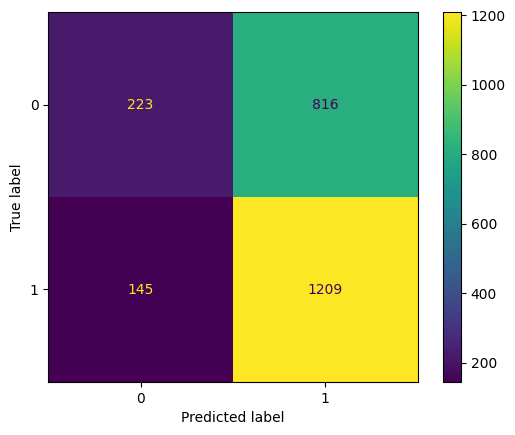

In [ ]:
log = LogisticRegression(random_state=seed)

log_model = ModelEval(log, 'log_4F_8var_10', results_df, residuals_df, stats, None)
log_model.full_diag()

# results_df

Dans ce bloc, on crée et on évalue un premier modèle de prédiction avec une régression logistique, un algorithme simple et rapide qui permet de prédire une issue binaire : ici, si l’équipe à domicile va gagner (1) ou perdre (0). Le modèle utilise 8 variables correspondant aux 4 "facteurs clés" du basket (adresse au tir, lancers francs, rebonds offensifs et pertes de balle), séparés pour les deux équipes (domicile et extérieur), en prenant la moyenne sur leurs 10 derniers matchs. On utilise une classe appelée ModelEval, qui automatise tout le processus : elle entraîne le modèle, fait les prédictions, calcule les scores de performance (sur les données d’entraînement, de test, et en validation croisée), affiche une matrice de confusion et stocke les résultats dans un tableau. Ici, on ne fait pas de réglage fin du modèle (pas de recherche d’hyperparamètres), ce qui permet d’avoir une première estimation rapide de ses performances, que l’on pourra comparer ensuite avec d’autres modèles plus complexes.

Score d'entraînement : 60,7 % → le modèle a bien appris à prédire les matchs déjà vus.

Score de test : 59,8 % → sur des matchs jamais vus, il fait presque aussi bien.

Cross-validation (cv_score) : 60 % → c’est une évaluation plus fiable de sa performance générale.

Le modèle atteint une précision de 59,8 % sur les données de test, ce qui est très proche du score de validation croisée (60 %). Cela suggère que le modèle n’est probablement pas surajusté (overfit). La matrice de confusion montre qu’il a tendance à prédire très souvent la victoire de l’équipe à domicile (valeur prédite = 1). Cette préférence génère beaucoup de faux positifs, c’est-à-dire des cas où l’équipe à domicile est annoncée gagnante alors qu’elle perd en réalité. C’est un biais important dont il faudra tenir compte lors de la comparaison avec d’autres modèles.

#### Logistic Regression (4 variables)

Dans ce second test, on simplifie le modèle en combinant les statistiques des deux équipes en une seule valeur par facteur. Par exemple, pour l’adresse au tir (eFGp), le taux de lancers francs (FTr) et les rebonds offensifs (ORBp), on soustrait la performance de l’équipe à domicile à celle de l’équipe extérieure. Si le résultat est positif, cela signifie que l’équipe extérieure a été meilleure sur ses 10 derniers matchs, et inversement. Pour les pertes de balle (TOVp), c’est l’inverse : comme un taux plus bas est meilleur, un total positif signifie que l’équipe à domicile a fait moins d’erreurs que l’équipe extérieure. En réduisant ainsi le nombre de variables de 8 à 4, on cherche à simplifier le modèle tout en gardant les informations importantes. Cela peut aider à améliorer les performances du modèle en réduisant la complexité inutile.

In [ ]:
# combination des statistiques home et away
team_factor_10['eFGp'] = team_factor_10['a_eFGp'] - team_factor_10['h_eFGp']
team_factor_10['FTr'] = team_factor_10['a_FTr'] - team_factor_10['h_FTr']
team_factor_10['ORBp'] = team_factor_10['a_ORBp'] - team_factor_10['h_ORBp']
team_factor_10['TOVp'] = team_factor_10['a_TOVp'] - team_factor_10['h_TOVp']

stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

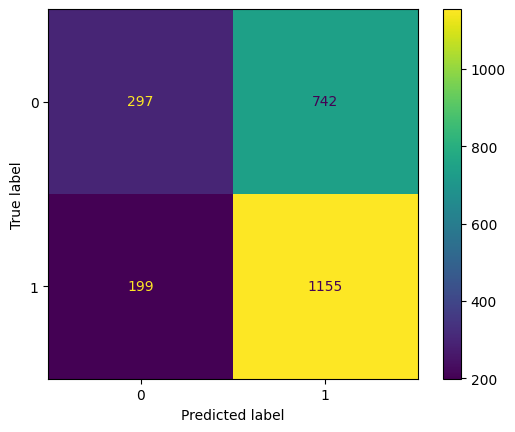

In [ ]:
logreg = LogisticRegression(random_state=seed)
logreg_model = ModelEval(logreg, 'log_4F_10', results_df, residuals_df, stats, None)
logreg_model.full_diag()

# results_df

En combinant les statistiques des deux équipes en seulement 4 variables, le nouveau modèle obtient une légère amélioration des performances : l’accuracy sur les données de test passe de 59,8 % à 60,7 %, soit environ 1 point de plus. Cela montre que simplifier le modèle peut parfois aider à mieux généraliser sans perdre d’informations utiles. La matrice de confusion montre cependant que le modèle a toujours tendance à prédire des victoires de l’équipe à domicile, mais un peu moins fortement que le modèle précédent, ce qui est un bon signe.

Même si cette amélioration est modeste, c’est suffisant pour privilégier ce modèle (avec 4 variables) pour la suite, tant qu’on n’a pas testé d’autres algorithmes.

#### Logistic regression Grid search

Cette fois, on améliore notre modèle de régression logistique en utilisant une recherche automatique des meilleurs paramètres (appelée Grid Search). Cette méthode permet de tester plusieurs combinaisons d’options pour voir lesquelles donnent les meilleurs résultats.

Parmi les paramètres testés, on change les pénalités appliquées au modèle. Ces pénalités permettent de limiter la complexité du modèle (on appelle cela la régularisation), afin d’éviter qu’il s’adapte trop fortement aux données d’entraînement.

Pour que cette régularisation fonctionne bien, il est nécessaire de mettre à l’échelle les données (les normaliser). On utilise ici le paramètre solver='saga', car c’est le seul algorithme compatible avec toutes les formes de pénalités testées.

Enfin, le paramètre C règle l’intensité de la régularisation : une petite valeur de C signifie une régularisation forte (le modèle est plus simple), alors qu’une grande valeur de C permet au modèle de s’adapter davantage aux données.

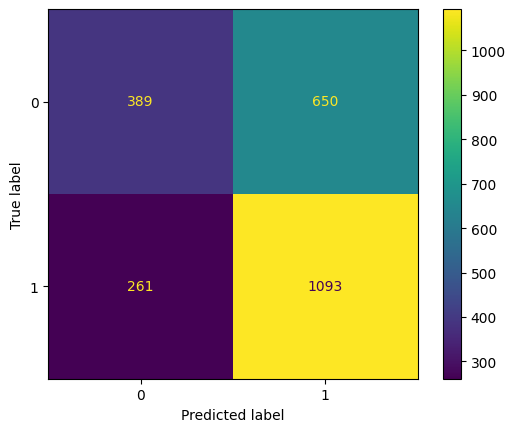

In [ ]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_10', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag()

# results_df

Dans ce test, on utilise à nouveau un modèle de régression logistique, mais cette fois en le rendant plus intelligent grâce à une recherche automatique des meilleurs réglages. C’est ce qu’on appelle une Grid Search.

On commence par définir un modèle (log_gs) qui utilise l’algorithme 'saga', nécessaire pour pouvoir tester différentes pénalités (façons de régulariser le modèle) :

'l1' : favorise des modèles simples, avec peu de variables.

'l2' : réduit les poids des variables sans en supprimer.

'elasticnet' : mélange des deux approches précédentes.

None : sans pénalité (pas de régularisation).

Ensuite, on teste plusieurs valeurs du paramètre C (0.01, 0.1, 1.0), qui contrôle l’intensité de la régularisation. Plus C est petit, plus le modèle est contraint.

Comme la régularisation est sensible aux différences d’échelle entre les variables, on active aussi la mise à l’échelle des données (scaler='yes'), ce qui permet au modèle de mieux fonctionner.

Enfin, avec log_gs_model.full_diag(), on lance l’évaluation complète du modèle, et on ajoute les résultats à notre tableau results_df.

Le modèle avec Grid Search (log_gs_4F_10) a obtenu un meilleur score de test que les modèles précédents :

Test score : 61,79 %, contre 60 % et 59,8 % pour les autres.

 le modèle continue de favoriser les victoires à domicile, même quand ce n’est pas le cas. C’est visible avec beaucoup de faux positifs (650).
Cela peut s’expliquer par un avantage réel du terrain, souvent présent en NBA : les équipes jouent mieux à la maison, donc le modèle a appris ce biais.

#### K-Nearest Neighbors (KNN)

Le modèle KNN prédit l’issue d’un match en se basant sur les matchs les plus similaires (appelés "voisins"). L’idée est simple : si plusieurs matchs passés aux caractéristiques proches se sont soldés par une victoire de l’équipe à domicile, il est probable que le match actuel aussi.

Ce modèle ne repose pas sur des formules mathématiques complexes mais sur la proximité entre les données. Pour cela, on utilise une normalisation des variables, afin qu’aucune statistique ne pèse trop dans le calcul.

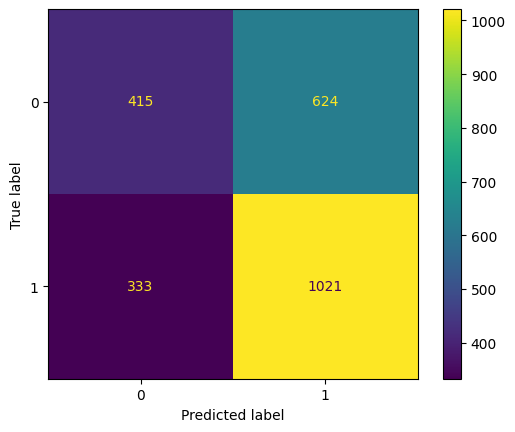

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_10', results_df, residuals_df, stats, knn_param_grid, scaler='yes')
knn_model.full_diag()

# results_df

Le modèle KNN prédit le résultat d’un match (victoire à domicile ou non) en regardant les matchs les plus similaires dans le passé. On suppose que des matchs "proches" auront des résultats semblables.

Pour cela, on utilise une recherche de paramètres (grid search) avec différentes options :

n_neighbors : le nombre de matchs similaires à considérer (17, 19 ou 21).

weights : soit tous les voisins comptent pareil (uniform), soit les plus proches comptent plus (distance).

p : méthode pour mesurer la ressemblance (distance de Manhattan, Euclidienne ou autre).

Le modèle teste toutes les combinaisons de ces paramètres (18 au total) pour trouver celle qui donne les meilleurs résultats. On utilise également un scaling des données (mise à l’échelle) pour améliorer la précision, car KNN est sensible aux différences d’échelle entre les variables.

Une fois entraîné, le modèle est évalué, et ses performances (précision, matrice de confusion, etc.) sont ajoutées au tableau de résultats pour pouvoir le comparer aux autres modèles testés.



Le modèle KNN obtient une précision de 60,1% sur les données de test, ce qui est légèrement meilleur que les précédents modèles de régression logistique. Cela montre qu’il est capable de faire des prédictions correctes un peu plus souvent.

On remarque aussi que le score sur les données d’entraînement (64,6%) est plus élevé, mais cela est normal puisque le KNN mémorise les exemples vus. Comme la différence avec le score test reste modérée, cela indique que le modèle n’est probablement pas surappris.

Enfin, la matrice de confusion montre encore une tendance à prédire la victoire de l’équipe à domicile (valeur 1), ce qui conduit à beaucoup de faux positifs : 616 matchs ont été annoncés comme gagnés à domicile, alors que ce n’était pas le cas.

#### Random Forest (RF)

Le modèle Random Forest est un algorithme d’apprentissage automatique qui utilise plusieurs arbres de décision pour prédire l’issue d’un match (victoire à domicile ou non). C’est ce qu’on appelle une méthode d’ensemble, car elle combine les décisions de plusieurs modèles simples pour obtenir une prédiction plus robuste.

Comme pour les modèles précédents, nous avons préparé une grille de paramètres (nombre d’arbres, profondeur maximale, etc.) afin d’optimiser les performances du modèle via une recherche par grille (grid search). Ces paramètres ont été définis après plusieurs essais afin de ne tester que les plus prometteurs.


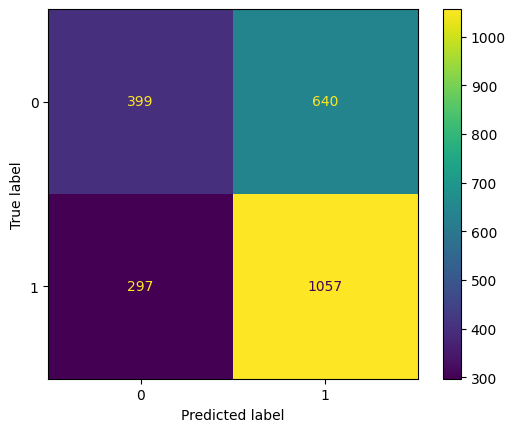

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [130, 140, 150],
    'max_depth': [5, 6],
    'min_samples_split': [2],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_10', results_df, residuals_df, stats, rfc_param_grid)
rfc_model.full_diag()

# results_df

Dans cette étape, on utilise un modèle Random Forest, qui combine plusieurs arbres de décision pour améliorer la précision des prédictions. Le modèle est testé avec différentes valeurs d’hyperparamètres grâce à une recherche par grille (grid search).
Voici ce que l’on teste :

n_estimators : nombre d’arbres (130, 140 ou 150) – plus il y a d’arbres, plus le modèle est stable, mais plus il est long à entraîner.

max_depth : profondeur maximale des arbres (5 ou 6) – limite la complexité pour éviter le surapprentissage.

max_features : nombre de variables utilisées à chaque split (soit la racine carrée du total, soit toutes les variables).

Les autres paramètres (criterion='gini', min_samples_split=2) restent fixes.

Après avoir entraîné le modèle avec ces combinaisons, on évalue sa performance avec l’outil ModelEval. Cela permet de comparer le score d’apprentissage (train_score) au score de test (test_score) pour vérifier que le modèle n’est pas surentraîné. Le tout est résumé dans le tableau results_df et visualisé avec une matrice de confusion.

Le modèle Random Forest atteint un test score de 0,6105, légèrement supérieur aux modèles précédents. Cela indique une bonne capacité à prédire les résultats des matchs à partir des 4 variables choisies.
La matrice de confusion montre que le modèle prédit mieux les victoires à domicile (1 059 cas corrects) que les défaites (402 cas corrects), ce qui confirme encore une tendance à favoriser l’équipe à domicile.

Cependant, bien que les performances soient bonnes, ce modèle est plus coûteux en ressources (temps de calcul, mémoire) que les autres, ce qui peut être un inconvénient si l’on cherche à appliquer le modèle rapidement ou sur de grands volumes de données.

#### Gaussian Naive Bayes (GNB)

Le modèle Gaussian Naive Bayes repose sur l’hypothèse que les données suivent une distribution normale (gaussienne). Comme notre jeu de données respecte assez bien cette hypothèse, ce modèle est particulièrement adapté à notre tâche de classification.

Il présente deux grands avantages :

Il est rapide à entraîner et à exécuter.

Il ne nécessite pas de recherche d’hyperparamètres, contrairement à d’autres modèles comme la régression logistique avec régularisation ou Random Forest.

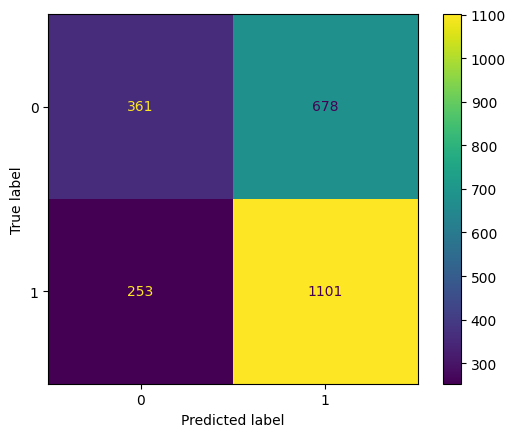

In [ ]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_10', results_df, residuals_df, stats, None)
gnb_model.full_diag()

# results_df

Le modèle GNB obtient une précision sur les données de test de 61,0 %, ce qui est légèrement supérieur à la plupart des autres modèles testés, y compris la régression logistique de base et KNN. Cela confirme que le modèle est bien adapté à des données proches d’une distribution normale.

Cependant, comme les autres modèles, il a tendance à prédire une victoire de l’équipe à domicile

#### Support Vector Classifier (SVC)

Le modèle SVC (Support Vector Classifier) cherche à séparer les données en deux classes (victoire à domicile ou à l’extérieur) en traçant un hyperplan optimal dans un espace multidimensionnel. Chaque point de données est projeté dans cet espace, et le modèle tente de maximiser la marge entre les deux classes.

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.600544,NaN,0.607546,0.598412
1,log_4F_10,0.610368,NaN,0.615803,0.606770
2,log_gs_4F_10,NaN,0.617893,0.618834,0.619306
3,knn_4F_10,NaN,0.590613,0.646112,0.600084
4,rfc_4F_10,NaN,0.620506,0.636392,0.608441
5,gnb_4F_10,0.613921,NaN,0.617057,0.610949
6,svc_4F_10,NaN,0.618207,0.626359,0.608023


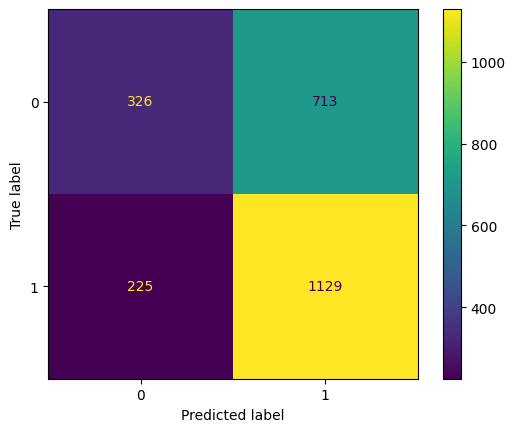

In [ ]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_10', results_df, residuals_df, stats, svc_param_grid, scaler='yes')
svc_model.full_diag()

results_df

Après une première phase de modélisation, tous les modèles testés atteignent une précision moyenne d’environ 60 %, ce qui représente une amélioration par rapport au modèle de base (57,2 %), mais reste inférieur à l’objectif fixé de 68 %. Les matrices de confusion montrent des biais similaires : les modèles génèrent beaucoup de faux positifs, ce qui suggère qu’ils ont tendance à prédire une victoire à domicile même lorsqu’elle n’a pas lieu. Ce phénomène peut être dû au manque de données discriminantes entre les deux classes. Pour approfondir cette hypothèse, d’autres formes d’agrégation des données seront testées.

### 4 facteurs : 20 derniers matchs
On repete le processus sur les 20 derniers match

In [ ]:
team_factor_20.dropna(inplace=True)
team_factor_20.reset_index(drop=True, inplace=True)

In [ ]:
team_factor_20['eFGp'] = team_factor_20['a_eFGp'] - team_factor_20['h_eFGp']
team_factor_20['FTr'] = team_factor_20['a_FTr'] - team_factor_20['h_FTr']
team_factor_20['ORBp'] = team_factor_20['a_ORBp'] - team_factor_20['h_ORBp']
team_factor_20['TOVp'] = team_factor_20['a_TOVp'] - team_factor_20['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_20 = pd.DataFrame(columns=['y_true'])
residuals_df_20['y_true'] = game_info['result']

In [ ]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_20[stat_columns]
y = team_factor_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

In [ ]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_20', results_df, residuals_df_20, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag(show_matrix=False)

# results_df

#### KNN

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [19, 21, 23],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_20', results_df, residuals_df_20, stats, knn_param_grid, scaler='yes')
knn_model.full_diag(show_matrix=False)

# results_df

#### RF

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [225, 250],
    'max_depth': [5, 6],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_20', results_df, residuals_df_20, stats, rfc_param_grid)
rfc_model.full_diag(show_matrix=False)

# results_df

#### GNB

In [ ]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_20', results_df, residuals_df_20, stats, None)
gnb_model.full_diag(show_matrix=False)

# results_df

#### SVC

In [ ]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_20', results_df, residuals_df_20, stats, svc_param_grid, scaler='yes')
svc_model.full_diag(show_matrix=False)

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.600544,NaN,0.607546,0.598412
1,log_4F_10,0.610368,NaN,0.615803,0.606770
2,log_gs_4F_10,NaN,0.617893,0.618834,0.619306
3,knn_4F_10,NaN,0.590613,0.646112,0.600084
4,rfc_4F_10,NaN,0.620506,0.636392,0.608441
5,gnb_4F_10,0.613921,NaN,0.617057,0.610949
6,svc_4F_10,NaN,0.618207,0.626359,0.608023
7,log_gs_4F_20,NaN,0.629911,0.629494,0.620560
8,knn_4F_20,NaN,0.605141,0.650293,0.591308
9,rfc_4F_20,NaN,0.630329,0.656773,0.617217


Le dataset basé sur les 20 derniers matchs montre une légère amélioration des performances, de l’ordre de 1 à 2 %, par rapport au dataset à 10 matchs. Bien que cela reste en dessous de l’objectif visé, ces résultats confirment les recherches antérieures selon lesquelles le nombre optimal de matchs passés pour prédire les résultats se situe entre 20 et 30. Je vais maintenant répéter le processus de modélisation avec le dataset à 30 matchs, en m’attendant à des performances similaires à celles obtenues avec 20 matchs.

### 4 facteurs : 30 derniers matchs

In [ ]:
team_factor_30.dropna(inplace=True)
team_factor_30.reset_index(drop=True, inplace=True)

In [ ]:
team_factor_30['eFGp'] = team_factor_30['a_eFGp'] - team_factor_30['h_eFGp']
team_factor_30['FTr'] = team_factor_30['a_FTr'] - team_factor_30['h_FTr']
team_factor_30['ORBp'] = team_factor_30['a_ORBp'] - team_factor_30['h_ORBp']
team_factor_30['TOVp'] = team_factor_30['a_TOVp'] - team_factor_30['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_30 = pd.DataFrame(columns=['y_true'])
residuals_df_30['y_true'] = game_info['result']

In [ ]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_30[stat_columns]
y = team_factor_30['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

In [ ]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_gs_model = ModelEval(log_gs, 'log_gs_4F_30', results_df, residuals_df_30, stats, log_param_grid, scaler='yes')
log_gs_model.full_diag(show_matrix=False)

# results_df

#### KNN

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_model = ModelEval(knn, 'knn_4F_30', results_df, residuals_df_30, stats, knn_param_grid, scaler='yes')
knn_model.full_diag(show_matrix=False)

# results_df

#### RF

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [175, 200],
    'max_depth': [5, 7],
    'min_samples_split': [2],
    'min_samples_leaf': [3, 4],
    'max_features': ['sqrt', None]
}

rfc_model = ModelEval(rfc, 'rfc_4F_30', results_df, residuals_df_30, stats, rfc_param_grid)
rfc_model.full_diag(show_matrix=False)

# results_df

#### GNB

In [ ]:
gnb = GaussianNB()
gnb_model = ModelEval(gnb, 'gnb_4F_30', results_df, residuals_df_30, stats, None)
gnb_model.full_diag(show_matrix=False)

# results_df

#### SVC

In [ ]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_model = ModelEval(svc, 'svc_4F_30', results_df, residuals_df_30, stats, svc_param_grid, scaler='yes')
svc_model.full_diag(show_matrix=False)

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.600544,NaN,0.607546,0.598412
1,log_4F_10,0.610368,NaN,0.615803,0.606770
2,log_gs_4F_10,NaN,0.617893,0.618834,0.619306
3,knn_4F_10,NaN,0.590613,0.646112,0.600084
4,rfc_4F_10,NaN,0.620506,0.636392,0.608441
5,gnb_4F_10,0.613921,NaN,0.617057,0.610949
6,svc_4F_10,NaN,0.618207,0.626359,0.608023
7,log_gs_4F_20,NaN,0.629911,0.629494,0.620560
8,knn_4F_20,NaN,0.605141,0.650293,0.591308
9,rfc_4F_20,NaN,0.630329,0.656773,0.617217


Les résultats obtenus avec le dataset basé sur les 30 derniers matchs sont mitigés. Cela correspond à mes attentes. Toutefois, les performances restent inférieures à l’objectif de 68 % de précision. Je vais donc tester les autres jeux de données avant de décider de la suite de l’analyse.

### Principal component analysis (PCA)

Dans ce projet, on utilise l’ensemble complet des données, qui contient 58 variables. Cela inclut toutes les statistiques classiques et avancées des matchs NBA dont certaines de ces variables sont liées entre elles en se répètant parfois et d’autres ne sont pas très utiles.

On va donc utiliser la PCA qui transforme les données de manière à les simplifier tout en gardant l’essentiel de l'ionformation. L’inconvénient, c’est que les nouvelles variables créées par la PCA ne correspondent plus à une seule statistique claire, mais à un mélange de plusieurs. Malgré cela, ces nouvelles variables peuvent quand même être très utiles pour prédire les résultats.

Après quelques tests, nous avons choisi de garder seulement 10 nouvelles variables (n_components=10). Ajouter plus de variables permettrait de garder un peu plus d’information, mais cela apporte de moins en moins de valeur. Donc, 10 semble être un bon équilibre entre simplicité et efficacité pour la modélisation.

In [ ]:
team_full_20

,game_id,season,date,away_team,away_score,home_team,home_score,result,a_FG,a_FGA,a_FGp,a_3P,a_3PA,a_3Pp,a_FT,a_FTA,a_FTp,a_ORB,a_DRB,a_TRB,a_AST,a_STL,a_BLK,a_TOV,a_PF,a_PTS,a_TSp,a_eFGp,a_3PAr,a_FTr,a_ORBp,a_DRBp,a_TRBp,a_ASTp,a_STLp,a_BLKp,a_TOVp,h_FG,h_FGA,h_FGp,h_3P,h_3PA,h_3Pp,h_FT,h_FTA,h_FTp,h_ORB,h_DRB,h_TRB,h_AST,h_STL,h_BLK,h_TOV,h_PF,h_PTS,h_TSp,h_eFGp,h_3PAr,h_FTr,h_ORBp,h_DRBp,h_TRBp,h_ASTp,h_STLp,h_BLKp,h_TOVp
0,131410290001,1314,2013-10-29,ORL,87,IND,97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131410290002,1314,2013-10-29,CHI,95,MIA,107,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131410290003,1314,2013-10-29,LAC,103,LAL,116,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131410300004,1314,2013-10-30,BRK,94,CLE,98,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131410300005,1314,2013-10-30,BOS,87,TOR,93,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,222304091226,2223,2023-04-09,UTA,117,LAL,128,1,42.60,90.70,0.47090,11.30,34.15,0.32895,18.95,24.50,0.78135,11.85,37.15,49.00,26.40,5.15,6.00,15.25,19.85,115.45,0.57035,0.53335,0.37760,0.27220,26.085,79.330,53.455,61.940,5.010,11.225,13.105,41.75,86.15,0.48590,11.45,31.00,0.36950,22.10,28.35,0.77915,10.70,34.95,45.65,25.20,6.40,4.70,13.75,16.55,117.05,0.59490,0.55275,0.36035,0.33430,25.150,76.800,51.830,60.475,6.470,8.005,12.225
11975,222304091227,2223,2023-04-09,NOP,108,MIN,113,1,41.70,85.25,0.48935,12.00,29.55,0.40445,18.35,22.15,0.83635,9.10,33.30,42.40,26.85,7.35,4.15,13.40,19.70,113.75,0.59895,0.55930,0.34625,0.26255,22.615,78.270,51.505,64.235,7.595,8.440,12.345,43.25,88.90,0.48655,12.85,32.65,0.38960,16.80,23.85,0.70280,9.40,34.10,43.50,28.35,7.70,5.65,13.40,20.70,116.15,0.58385,0.55895,0.36755,0.27040,21.240,76.535,49.115,65.430,7.595,9.405,11.860
11976,222304091228,2223,2023-04-09,MEM,100,OKC,115,1,45.10,91.15,0.49390,14.45,37.70,0.37950,16.20,21.10,0.76275,9.90,33.55,43.45,28.45,7.95,4.95,12.00,20.05,120.85,0.60220,0.57320,0.41535,0.23260,22.735,76.355,49.665,63.075,7.850,9.585,10.655,41.70,91.85,0.45405,11.95,35.20,0.33895,21.25,25.60,0.83435,11.10,31.75,42.85,23.15,8.35,2.75,11.20,20.05,116.60,0.56515,0.51885,0.38285,0.28235,24.340,73.755,48.455,55.740,8.295,5.350,9.810
11977,222304091229,2223,2023-04-09,LAC,119,PHO,114,0,43.25,86.20,0.50325,13.20,33.35,0.38875,20.15,25.25,0.78660,9.25,32.70,41.95,27.15,8.10,3.90,14.30,19.60,119.85,0.61595,0.58010,0.38725,0.29405,22.060,74.800,49.295,62.720,8.100,6.675,12.760,43.50,91.10,0.47940,11.70,32.30,0.35535,17.30,21.75,0.80215,11.55,33.05,44.60,27.55,6.70,6.35,11.70,21.85,116.00,0.57835,0.54455,0.35740,0.24130,25.815,77.880,51.535,63.335,6.795,12.130,10.415


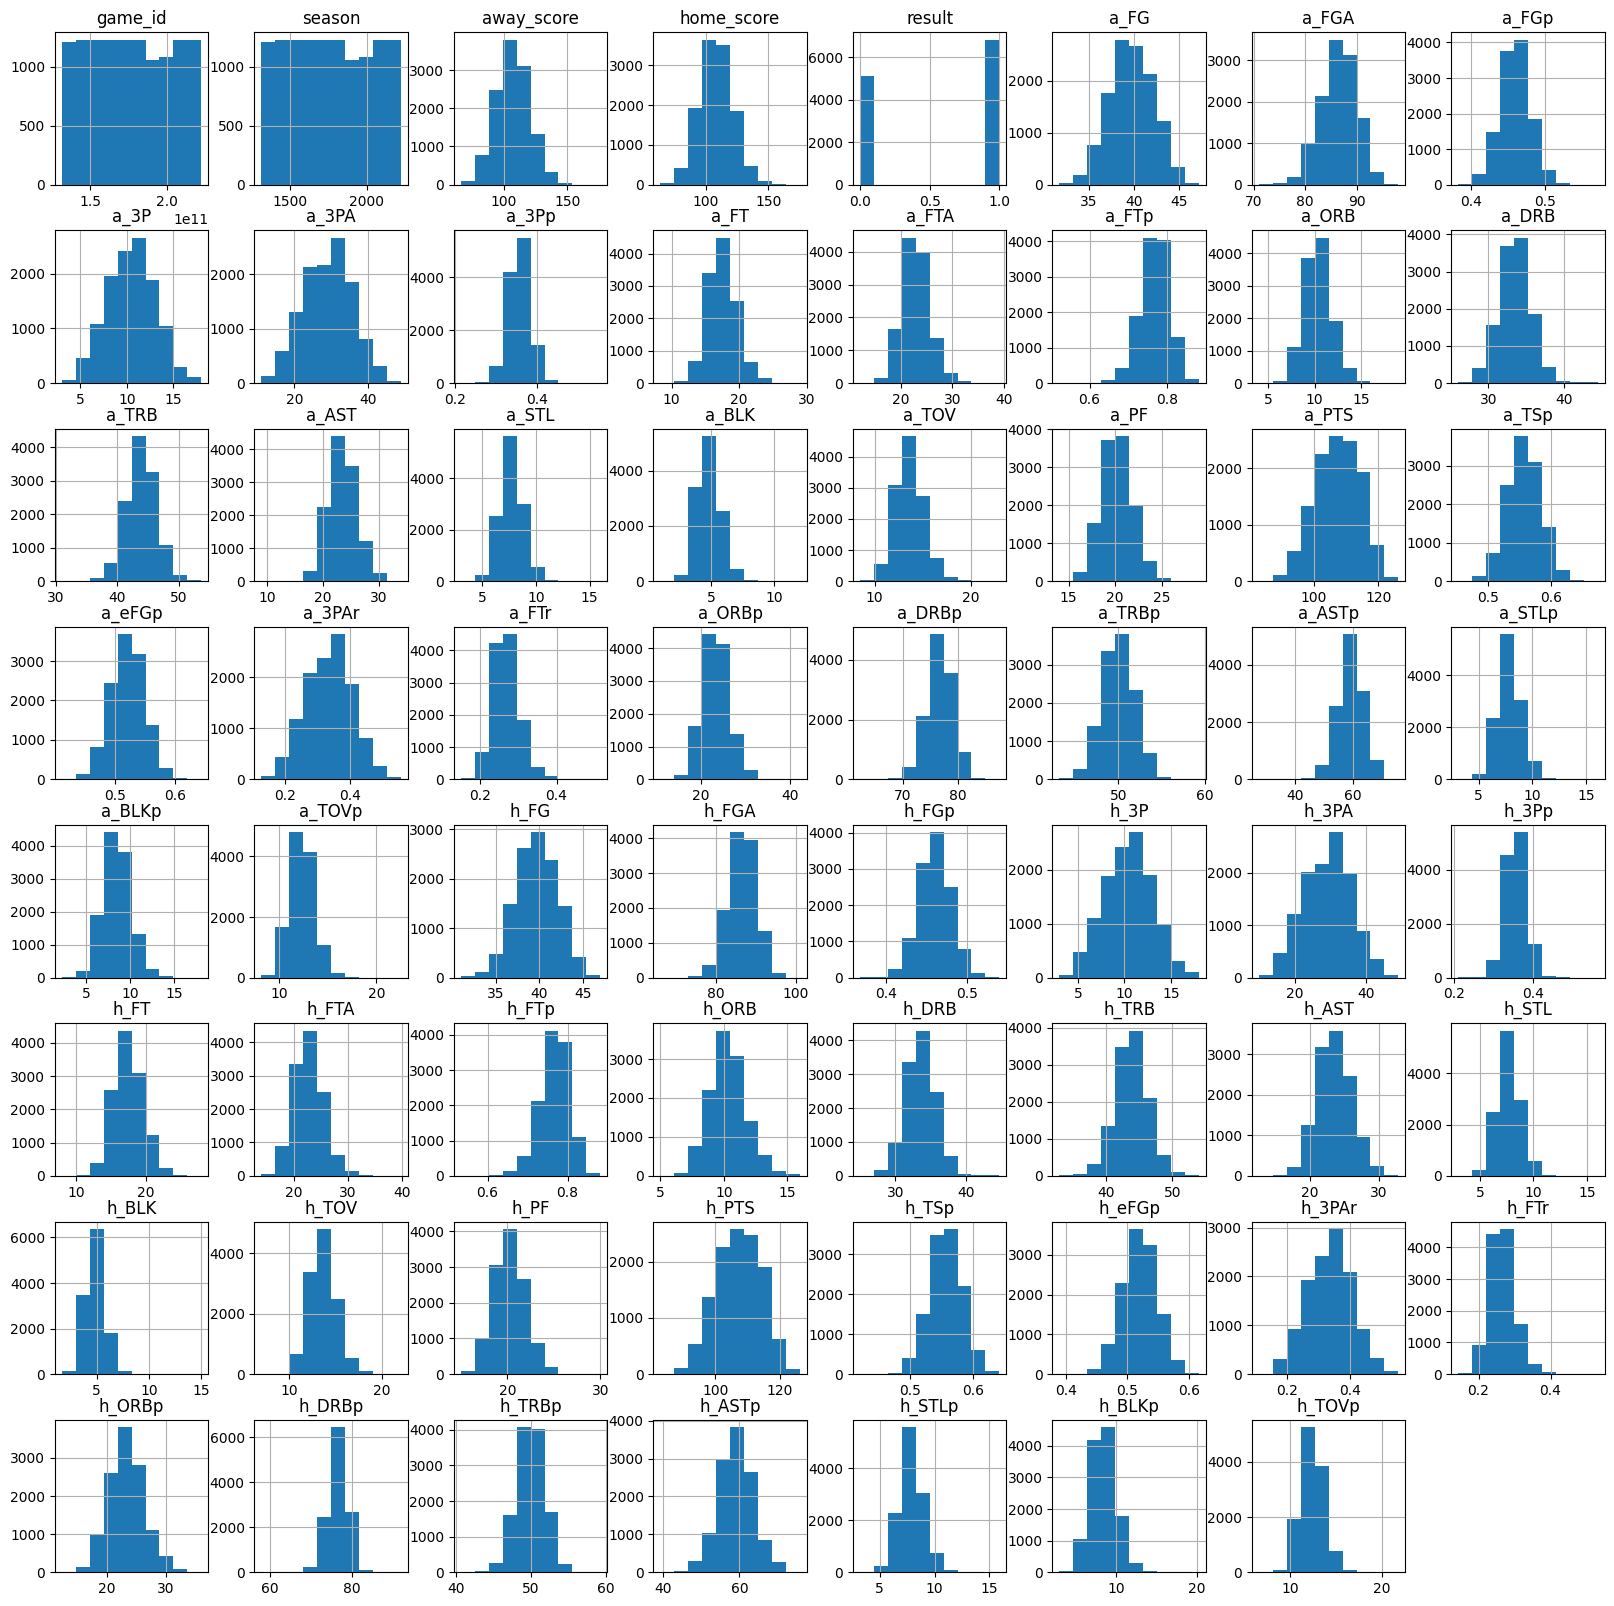

In [ ]:
team_full_20.dropna(inplace=True)
team_full_20.reset_index(drop=True, inplace=True)
team_full_20.hist(figsize=(20,20)); # permet de voir la distribution de chaque variable (moyenne, dispersion...)

In [ ]:
stat_columns = team_full_20.loc[:,'a_FG':'h_TOVp'].columns #sélection de toutes les colonnes de stats (en excluant les scores et game_id)

X = team_full_20[stat_columns] #statistiques
y = team_full_20['result'] #résultats des matchs

stats = train_test_split(X, y, train_size=.80, random_state=seed)

residuals_df_pca = pd.DataFrame(columns=['y_true'])
residuals_df_pca['y_true'] = team_full_20['result']

In [ ]:
# pipeline de PCA puis regression logistique
pipeline = Pipeline([
    ('pca', PCA()),
    ('logreg', LogisticRegression())
])


param_grid = {
    'pca__n_components': [x for x in range(1,30)], #on garde à peu près la moitié des variables
    'logreg__C': [0.1, 1, 10] #on teste plusieurs régularisations
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5) #cross validation en 5 plis
grid_search.fit(stats[0], stats[2])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1, 10],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29]})

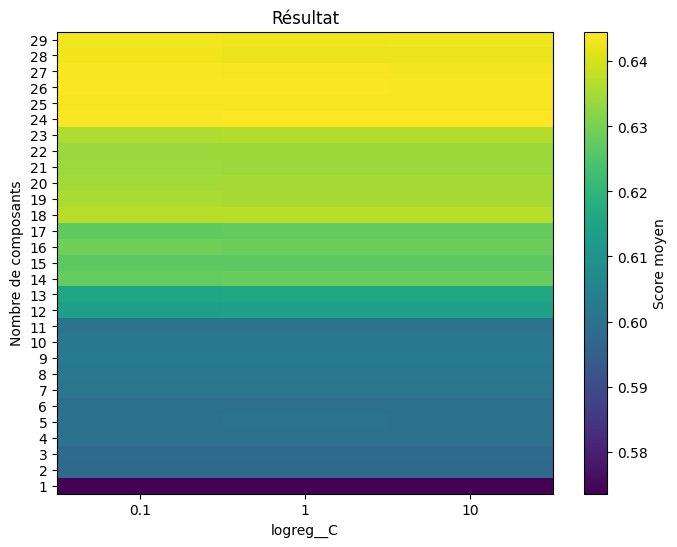

In [ ]:
pca_results_df = pd.DataFrame(grid_search.cv_results_).dropna()
pivot = pca_results_df.pivot(index = 'param_pca__n_components', columns='param_logreg__C', values='mean_test_score') #met les résultats de la grid search dans un tableau, et les transforme en matrice pivot

plt.figure(figsize=(8, 6))
plt.title('Résultat')
plt.xlabel('logreg__C')
plt.ylabel('Nombre de composants')

plt.imshow(pivot, cmap=plt.get_cmap('viridis'), aspect='auto', origin='lower')
plt.xticks(np.arange(len(param_grid['logreg__C'])), param_grid['logreg__C'])
plt.yticks(np.arange(len(param_grid['pca__n_components'])), param_grid['pca__n_components'])
plt.colorbar(label='Score moyen')
plt.show()

In [ ]:
# obtention des meilleurs paramètres et estimateurs
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# prédiction avec le meilleur estimateur sur les données de test
y_pred = best_estimator.predict(stats[1])

# calcul de la précision
accuracy = accuracy_score(stats[3], y_pred)
print(f"Meilleurs paramètres: {best_params}")
print(f"Précision du test: {accuracy:.3f}")

Meilleurs paramètres: {'logreg__C': 1, 'pca__n_components': 24}
Précision du test: 0.629


on remarque que la régularisation a eu peu d’impact pendant les tests, mais on a observé une amélioration progressive du score de validation jusqu’à ce que le nombre de composantes atteigne 24, après les scores se stabilisent. Donc, nous allons utiliser n_components=24 pour tester les différents modèles.


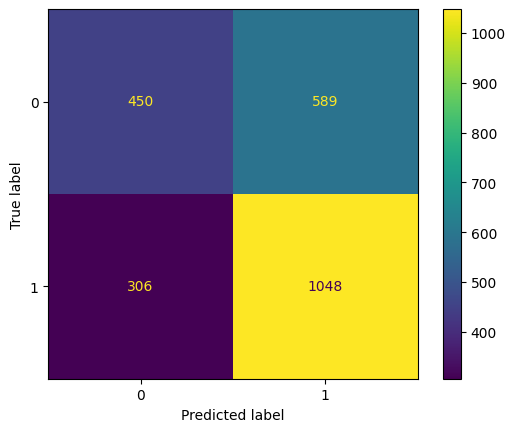

In [ ]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0],
}

log_pca = ModelEval(log_gs, 'log_pca', results_df, residuals_df_pca, stats, log_param_grid, pca='yes', n_components=24)
log_pca.full_diag()

In [ ]:
log_pca.params_model

LogisticRegression(C=0.01, random_state=99, solver='saga')

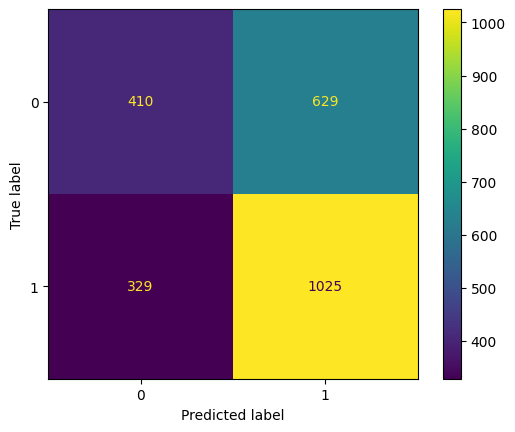

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [15, 17], #nombre de voisins a prendre en compte
    'weights': ['uniform', 'distance'], #choix du poids des distances entre les voisins
    'p': [1, 2, 3]
}

knn_pca = ModelEval(knn, 'knn_pca', results_df, residuals_df_pca, stats, knn_param_grid, pca='yes', n_components=24)
knn_pca.full_diag()

In [ ]:
knn_pca.params_model

KNeighborsClassifier(n_neighbors=17, p=3, weights='distance')

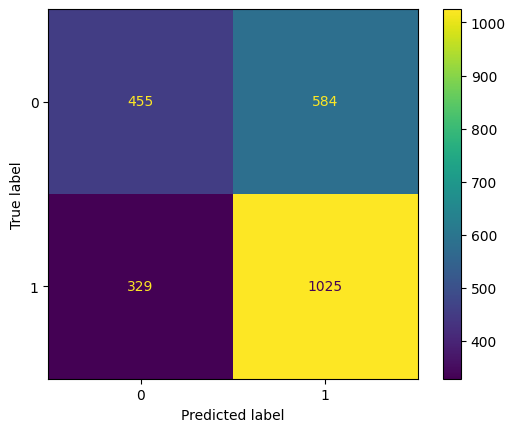

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [225, 250],
    'max_depth': [5, 6], #limite la profondeur de l'arbre pour éviter des arbres trop complexes
    'min_samples_split': [2],
    'min_samples_leaf': [5], #on  évite les feuilles trop petites pour réduire surapprentissage
    'max_features': ['sqrt', None]
}

rfc_pca = ModelEval(rfc, 'rfc_pca', results_df, residuals_df_pca, stats, rfc_param_grid, pca='yes', n_components=24)
rfc_pca.full_diag()

In [ ]:
rfc_pca.params_model

RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=5,
                       n_estimators=250, random_state=99)

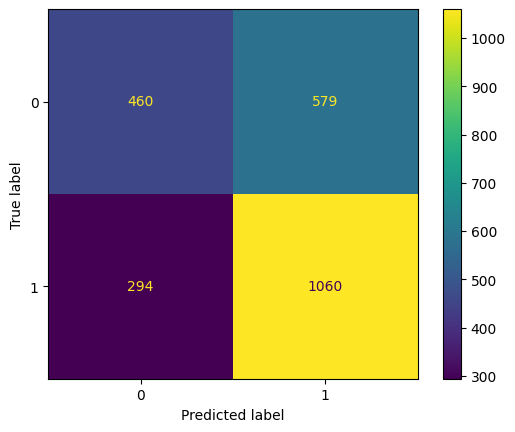

In [ ]:
gnb = GaussianNB()
gnb_pca = ModelEval(gnb, 'gnb_pca', results_df, residuals_df_pca, stats, None, pca='yes', n_components=24)
gnb_pca.full_diag()

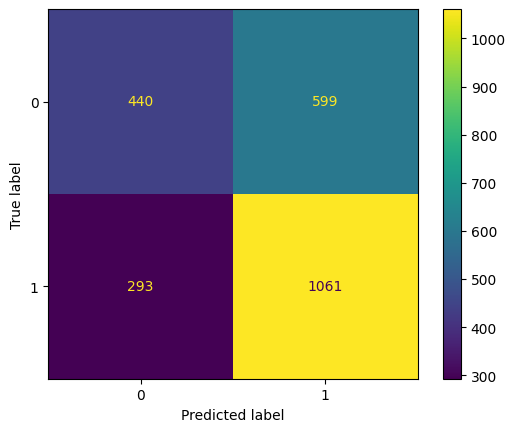

In [ ]:
svc = SVC(random_state=seed)
svc_param_grid = {
    'C': [0.1, 1, 10], #pénalité d'erreur
    'kernel': ['linear', 'rbf'], #séparation linéaire ou non
    'gamma': ['scale', 'auto']
}

svc_pca = ModelEval(svc, 'svc_pca', results_df, residuals_df_pca, stats, svc_param_grid, pca='yes', n_components=24)
svc_pca.full_diag()


In [ ]:
svc_pca.params_model

SVC(C=0.1, kernel='linear', random_state=99)

La PCA a permis d’améliorer encore les performances par rapport au dataset à quatre facteurs.
Le modèle le plus performant est le GNB, avec un score de 0.635.

La matrice de confusion montre bien que le modèle réduit les faux positifs et augmente en contrepartie les vrais négatifs, améliorant ainsi la prédiction des victoires à l’extérieur jusque-là mal captées.

Cependant l’interprétation des résultats devient difficile, car les nouvelles variables issues de la PCA sont des combinaisons des statistiques d’origine.


### Sélection de variables

Pour retrouver de l’interprétabilité, je vais tester la sélection de variables sur le dataset complet (sans PCA) :

Fusionner les stats domicile et extérieur en une seule colonne par variable.

Utiliser le score F d’ANOVA pour identifier les variables les plus discriminantes.

In [ ]:
combo_cols = team_stats.drop(['game_id', 'team', 'MP', 'PM', 'USGp', 'ORtg', 'DRtg', 'BPM'], axis=1).columns #on retire les metriques globales ou trop complexes

for column in combo_cols:
    team_full_20[column] = team_full_20['a_'+column] - team_full_20['h_'+column] #pour chaque variables on calcule la différence entre l'équipe a domicile ou ext.
team_full_20_combined = team_full_20.loc[:, 'FG':'TOVp'] #nouveau df avec colonnes combinées
team_full_20_combined

,FG,FGA,FGp,3P,3PA,3Pp,FT,FTA,FTp,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TSp,eFGp,3PAr,FTr,ORBp,DRBp,TRBp,ASTp,STLp,BLKp,TOVp
0,1.00,-12.00,0.08500,-4.00,-13.00,-0.03800,-3.00,-6.00,0.09900,-5.00,-2.00,-7.00,-6.00,1.00,2.00,4.0,-11.00,-5.00,0.06300,0.06400,-0.13000,-0.03800,-5.100,-0.900,1.700,-18.500,1.500000e+00,2.600,5.700
1,5.00,3.00,0.04100,7.00,6.00,0.17500,5.00,0.00,0.21800,-3.00,11.00,8.00,7.00,-3.00,5.00,-1.0,1.00,22.00,0.09700,0.08000,0.06100,-0.01000,-3.800,19.500,11.700,8.000,-3.200000e+00,6.400,-1.200
2,2.00,-6.00,0.05000,1.00,5.00,-0.06700,10.00,14.00,0.02600,4.00,7.00,11.00,7.00,-1.00,-3.00,4.0,-1.00,15.00,0.07500,0.05700,0.06800,0.18300,13.300,13.900,15.800,17.600,-1.300000e+00,-6.600,3.400
3,-7.50,-11.50,-0.02850,-4.50,-12.00,0.03300,8.50,7.00,0.20450,1.50,-5.00,-3.50,-2.00,-1.50,-1.00,-2.5,1.50,-11.00,-0.01200,-0.04850,-0.10800,0.10300,4.450,9.250,4.100,4.050,-7.000000e-01,1.050,-0.900
4,9.00,2.00,0.10200,-2.00,-4.00,-0.01900,-4.00,-8.00,0.08300,-5.00,7.00,2.00,1.00,11.00,-2.00,2.0,-9.00,12.00,0.07500,0.08800,-0.05800,-0.11000,-3.900,14.500,10.000,-11.800,1.080000e+01,-3.400,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,0.85,4.55,-0.01500,-0.15,3.15,-0.04055,-3.15,-3.85,0.00220,1.15,2.20,3.35,1.20,-1.25,1.30,1.5,3.30,-1.60,-0.02455,-0.01940,0.01725,-0.06210,0.935,2.530,1.625,1.465,-1.460000e+00,3.220,0.880
11957,-1.55,-3.65,0.00280,-0.85,-3.10,0.01485,1.55,-1.70,0.13355,-0.30,-0.80,-1.10,-1.50,-0.35,-1.50,0.0,-1.00,-2.40,0.01510,0.00035,-0.02130,-0.00785,1.375,1.735,2.390,-1.195,1.776357e-15,-0.965,0.485
11958,3.40,-0.70,0.03985,2.50,2.50,0.04055,-5.05,-4.50,-0.07160,-1.20,1.80,0.60,5.30,-0.40,2.20,0.8,0.00,4.25,0.03705,0.05435,0.03250,-0.04975,-1.605,2.600,1.210,7.335,-4.450000e-01,4.235,0.845
11959,-0.25,-4.90,0.02385,1.50,1.05,0.03340,2.85,3.50,-0.01555,-2.30,-0.35,-2.65,-0.40,1.40,-2.45,2.6,-2.25,3.85,0.03760,0.03555,0.02985,0.05275,-3.755,-3.080,-2.240,-0.615,1.305000e+00,-5.455,2.345


In [ ]:
X = team_full_20_combined
y = team_full_20['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=seed)

On examine maintenant la corrélation des variables

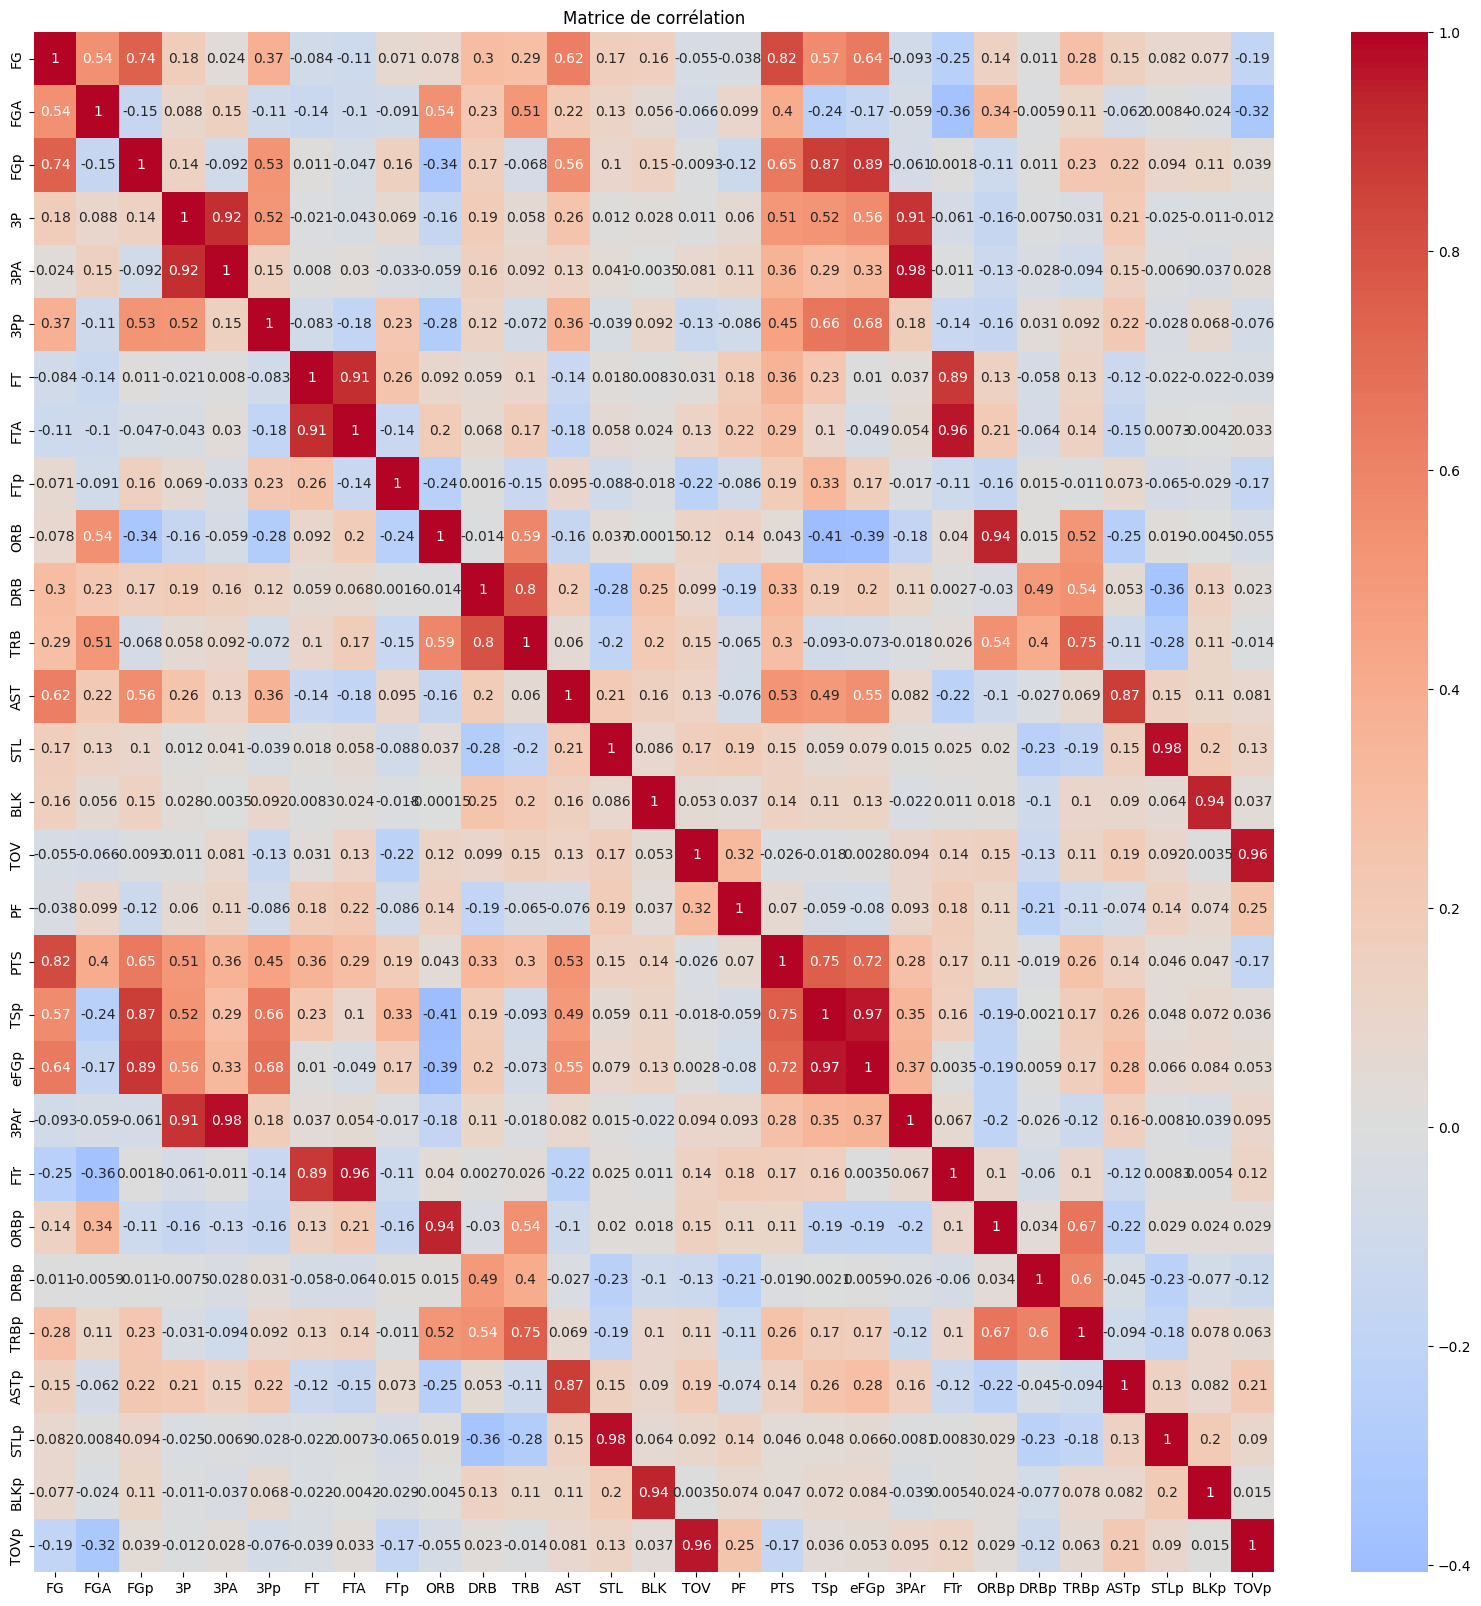

In [ ]:
correlation_matrix = X_train.corr()

# Visualisation de la matrice avec une heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()

Il y a plusieurs statistiques très similaires et fortement corrélées, comme les stats de tir ou de rebonds

On teste le modèle GNB, en ajoutant une sélection de variables (f_classif) pour choisir les meilleures k features. Ensuite, nous afficherons l’exactitude moyenne en validation croisée pour chaque valeur de k afin de déterminer le nombre optimal de variables à garder.

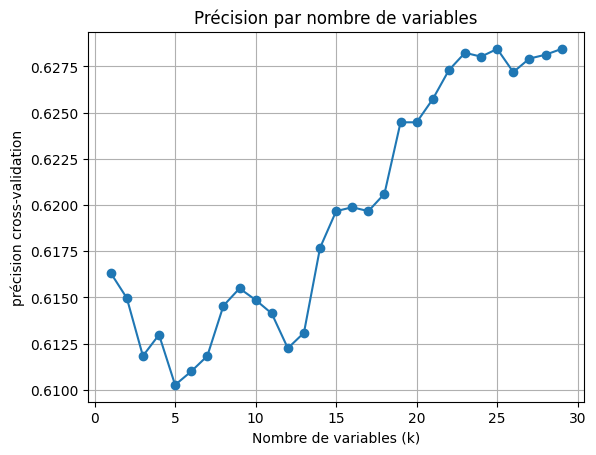

In [ ]:
pipe = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('gnb', GaussianNB())
])

# valeurs de k a tester
k_values = np.arange(1, 30)

# sauvegarde des scores de la validation croisée pour chaque valeur de k
cv_scores = []

# Validation croisée
for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))


plt.plot(k_values, cv_scores, marker='o')
plt.title('Précision par nombre de variables')
plt.xlabel('Nombre de variables (k)')
plt.ylabel('précision cross-validation')
plt.grid(True)
plt.show();

Au début, la précision varie beaucoup, puis augmente nettement avec le nombre de variables, avant de se stabiliser autour de 25 variables.

Pour mieux comprendre l’importance de chaque variable, nous refaisons le test avec une régression logistique, qui permet d’évaluer le poids de chaque variable.


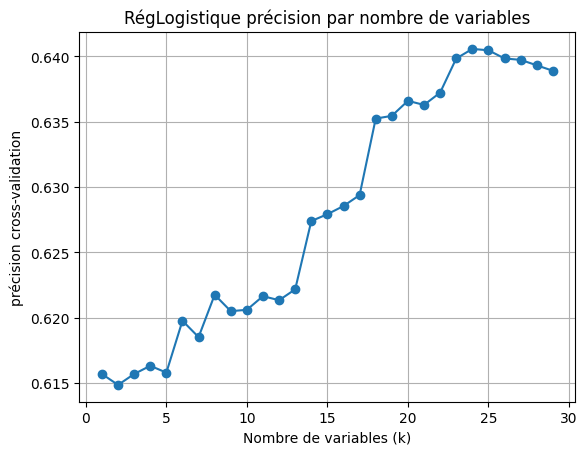

In [ ]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('lr', LogisticRegression(C=0.01, random_state=99, solver='saga'))
])


k_values = np.arange(1, 30)

cv_scores = []

for k in k_values:
    pipe.set_params(feature_selection__k=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=3)
    cv_scores.append(np.mean(scores))


plt.plot(k_values, cv_scores, marker='o')
plt.title('RégLogistique précision par nombre de variables')
plt.xlabel('Nombre de variables (k)')
plt.ylabel('précision cross-validation')
plt.grid(True)
plt.show();

Encore une fois, la précision du modèle continue d’augmenter jusqu’à environ k = 24.

Nous regardons maintenant quelles sont les variables les plus influentes dans les prédictions du modèle :

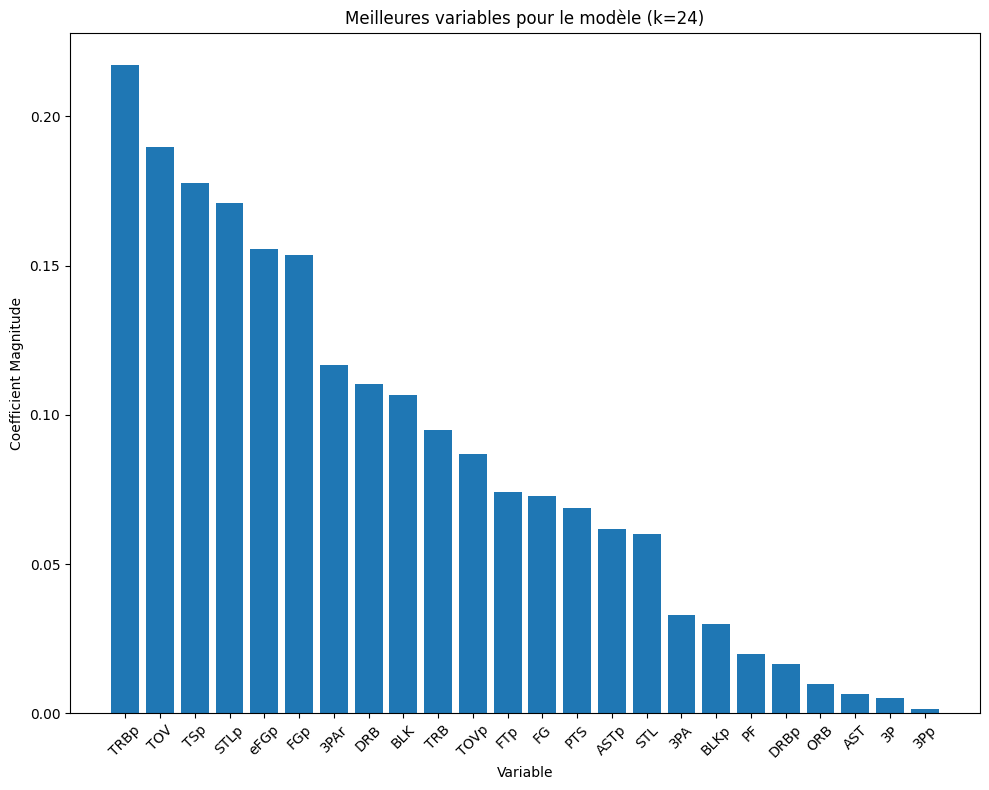

In [ ]:
# identification de la meilleur valeur de k
best_k = k_values[np.argmax(cv_scores)]

# Entrainer le modèle avec ce k
pipe.set_params(feature_selection__k=best_k)
best_model = pipe.fit(X_train, y_train)

# récupérer les indices et les noms des variables selectionnées
selected_feature_indices = best_model.named_steps['feature_selection'].get_support()
best_selected_feature_names = X.columns[selected_feature_indices]

# tri par importance des variables
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = best_selected_feature_names[sorted_indices]


plt.figure(figsize=(10,8))
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Meilleures variables pour le modèle (k={})'.format(best_k))
plt.xlabel('Variable')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

Selon le graph, les rebonds totaux (TRBp) et les balles perdues (TOV) sont les statistiques les plus déterminantes. Pourtant, selon les connaissances du domaine (les Four Factors) ce sont plutôt les statistiques de tir qui ont historiquement le plus d’impact.

Celà est du au fait que ce graphique montre l’importance relative des variables les unes par rapport aux autres.
Ainsi, quand plusieurs statistiques sont très corrélées entre elles (comme différents types de tirs), une seule d’entre elles va porter toute l’information, et les autres auront une importance quasi nulle non pas parce qu’elles sont inutiles, mais parce qu’elles n’apportent rien de nouveau au modèle.

On refait donc l'opération avec une valeur de k plus petite, pour voir quelles variables sont sélectionnées en premier et donc les plus "uniquement informatives".

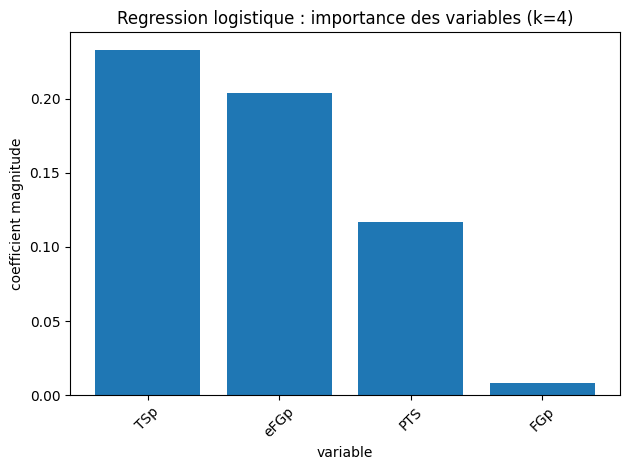

In [ ]:
pipe.set_params(feature_selection__k=4)
best_model = pipe.fit(X_train, y_train)


selected_feature_indices = best_model.named_steps['feature_selection'].get_support()
selected_feature_names = X.columns[selected_feature_indices]

# tri par importance des variables
feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]

plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Regression logistique : importance des variables (k=4)')
plt.xlabel('variable')
plt.ylabel('coefficient magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

Ce nouveau graphique montre que les quatre statistiques les plus importantes sont TSp, eFGp, PTS, et FGp toutes liées au scoring.
Pourtant, dans le premier graphique, PTS apparaissait en bas du classement, car d'autres stats de tir (comme eFGp ou TSp) transmettaient la même information, mais de façon plus efficace.

Cela montre que l’ordre d’apparition des variables importantes dépend du nombre de variables autorisées (k).
Pour affiner l’analyse, on peut regarder ce que donne le graphique lorsque k=8.

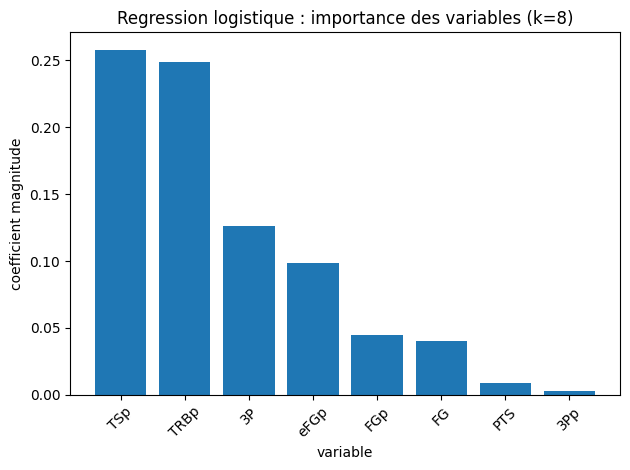

In [ ]:
pipe.set_params(feature_selection__k=8)
best_model = pipe.fit(X_train, y_train)


selected_feature_indices = best_model.named_steps['feature_selection'].get_support()
selected_feature_names = X.columns[selected_feature_indices]


feature_importances = np.abs(best_model.named_steps['lr'].coef_[0])
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]


plt.bar(sorted_feature_names, sorted_feature_importances)
plt.title('Regression logistique : importance des variables (k=8)')
plt.xlabel('variable')
plt.ylabel('coefficient magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

On observe maintenant que la statistique TRBp (total rebounding percentage) devient la 2e plus importante, car elle apporte une information nouvelle par rapport aux autres stats de tir déjà présentes dans les 8 premières variables.

Il serait donc plus pertinent de choisir une statistique représentative par catégorie (tir, rebond, lancers francs, pertes de balle), comme le propose déjà le concept des Four Factors.
Par exemple, TSp semble ici mieux représenter le tir que la eFGp, pourtant plus souvent utilisée.

In [ ]:
team_full_20_combined[best_selected_feature_names]

,FG,FGp,3P,3PA,3Pp,FTp,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TSp,eFGp,3PAr,DRBp,TRBp,ASTp,STLp,BLKp,TOVp
0,1.00,0.08500,-4.00,-13.00,-0.03800,0.09900,-5.00,-2.00,-7.00,-6.00,1.00,2.00,4.0,-11.00,-5.00,0.06300,0.06400,-0.13000,-0.900,1.700,-18.500,1.500000e+00,2.600,5.700
1,5.00,0.04100,7.00,6.00,0.17500,0.21800,-3.00,11.00,8.00,7.00,-3.00,5.00,-1.0,1.00,22.00,0.09700,0.08000,0.06100,19.500,11.700,8.000,-3.200000e+00,6.400,-1.200
2,2.00,0.05000,1.00,5.00,-0.06700,0.02600,4.00,7.00,11.00,7.00,-1.00,-3.00,4.0,-1.00,15.00,0.07500,0.05700,0.06800,13.900,15.800,17.600,-1.300000e+00,-6.600,3.400
3,-7.50,-0.02850,-4.50,-12.00,0.03300,0.20450,1.50,-5.00,-3.50,-2.00,-1.50,-1.00,-2.5,1.50,-11.00,-0.01200,-0.04850,-0.10800,9.250,4.100,4.050,-7.000000e-01,1.050,-0.900
4,9.00,0.10200,-2.00,-4.00,-0.01900,0.08300,-5.00,7.00,2.00,1.00,11.00,-2.00,2.0,-9.00,12.00,0.07500,0.08800,-0.05800,14.500,10.000,-11.800,1.080000e+01,-3.400,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,0.85,-0.01500,-0.15,3.15,-0.04055,0.00220,1.15,2.20,3.35,1.20,-1.25,1.30,1.5,3.30,-1.60,-0.02455,-0.01940,0.01725,2.530,1.625,1.465,-1.460000e+00,3.220,0.880
11957,-1.55,0.00280,-0.85,-3.10,0.01485,0.13355,-0.30,-0.80,-1.10,-1.50,-0.35,-1.50,0.0,-1.00,-2.40,0.01510,0.00035,-0.02130,1.735,2.390,-1.195,1.776357e-15,-0.965,0.485
11958,3.40,0.03985,2.50,2.50,0.04055,-0.07160,-1.20,1.80,0.60,5.30,-0.40,2.20,0.8,0.00,4.25,0.03705,0.05435,0.03250,2.600,1.210,7.335,-4.450000e-01,4.235,0.845
11959,-0.25,0.02385,1.50,1.05,0.03340,-0.01555,-2.30,-0.35,-2.65,-0.40,1.40,-2.45,2.6,-2.25,3.85,0.03760,0.03555,0.02985,-3.080,-2.240,-0.615,1.305000e+00,-5.455,2.345


In [ ]:
X = team_full_20_combined[best_selected_feature_names]
y = team_factor_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

#### Logistic Regression

In [ ]:
log_gs = LogisticRegression(solver='saga', random_state=seed)
log_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1.0,],
}

log_fs_model = ModelEval(log_gs, 'log_fs', results_df, residuals_df, stats, log_param_grid, scaler='yes')
log_fs_model.full_diag(show_matrix=False)

In [ ]:
log_fs_model.params_model

LogisticRegression(C=0.01, penalty=None, random_state=99, solver='saga')

#### KNN

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

knn_fs_model = ModelEval(knn, 'knn_fs', results_df, residuals_df, stats, knn_param_grid, scaler='yes')
knn_fs_model.full_diag(show_matrix=False)

In [ ]:
knn_fs_model.params_model

KNeighborsClassifier(n_neighbors=21)

#### RF

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [150, 200, 250],
    'max_depth': [6],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt', None]
}

rfc_fs_model = ModelEval(rfc, 'rfc_fs', results_df, residuals_df, stats, rfc_param_grid)
rfc_fs_model.full_diag(show_matrix=False)

In [ ]:
rfc_fs_model.params_model

RandomForestClassifier(max_depth=6, min_samples_leaf=4, n_estimators=200,
                       random_state=99)

#### GNB

In [ ]:
gnb = GaussianNB()
gnb_fs_model = ModelEval(gnb, 'gnb_fs', results_df, residuals_df, stats, None)
gnb_fs_model.full_diag(show_matrix=False)

#### SVC

In [ ]:
svc = SVC(random_state=seed)

svc_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_fs_model = ModelEval(svc, 'svc_fs', results_df, residuals_df, stats, svc_param_grid, scaler='yes')
svc_fs_model.full_diag(show_matrix=False)

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,log_4F_8var_10,0.600544,NaN,0.607546,0.598412
1,log_4F_10,0.610368,NaN,0.615803,0.606770
2,log_gs_4F_10,NaN,0.617893,0.618834,0.619306
3,knn_4F_10,NaN,0.590613,0.646112,0.600084
4,rfc_4F_10,NaN,0.620506,0.636392,0.608441
5,gnb_4F_10,0.613921,NaN,0.617057,0.610949
6,svc_4F_10,NaN,0.618207,0.626359,0.608023
7,log_gs_4F_20,NaN,0.629911,0.629494,0.620560
8,knn_4F_20,NaN,0.605141,0.650293,0.591308
9,rfc_4F_20,NaN,0.630329,0.656773,0.617217


In [ ]:
svc_fs_model.params_model

SVC(C=10, kernel='linear', random_state=99)

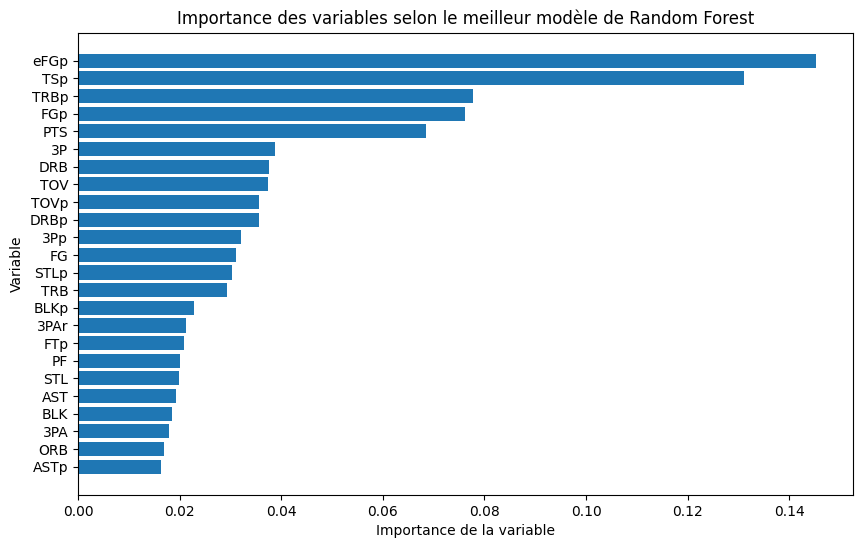

In [ ]:
feat_importances = rfc_fs_model.params_model.feature_importances_
feat_names = rfc_fs_model.params_model.feature_names_in_

sorted_indices = np.argsort(feat_importances)[::]
sorted_feat_importances = feat_importances[sorted_indices]
sorted_feat_names = [feat_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(list(range(len(sorted_feat_importances))), sorted_feat_importances, align='center')
plt.yticks(range(len(sorted_feat_importances)), sorted_feat_names)
plt.xlabel('Importance de la variable')
plt.ylabel('Variable')
plt.title('Importance des variables selon le meilleur modèle de Random Forest')
plt.show();

## Resultats

Maintenant que nous avons testé tous les modèles, voici le top 10 par score :

In [ ]:
top_10 = results_df.sort_values('test_score', ascending=False)[0:10].reset_index(drop=True)
top_10['test_score'] = round(top_10['test_score']*100, 1)
top_10.rename(columns={'test_score': 'test_accuracy'}, inplace=True)
top_10[['model_name', 'test_accuracy']]

,model_name,test_accuracy
0,gnb_pca,63.5
1,rfc_fs,63.2
2,log_fs,63.0
3,svc_pca,62.7
4,log_pca,62.6
5,svc_fs,62.5
6,svc_4F_30,62.2
7,svc_4F_20,62.1
8,log_gs_4F_20,62.1
9,log_gs_4F_30,62.1


Nous avons observé des améliorations progressives en passant d’une moyenne sur 10 matchs à une moyenne sur 20 matchs. Cependant, comme mentionné précédemment, les modèles d’apprentissage automatique testés ont tous présenté des comportements similaires : ils avaient tendance à favoriser l’équipe à domicile (faux positifs) et affichaient une répartition des erreurs relativement constante selon les saisons.

## Conclusion

Ce projet visait à mieux comprendre les dynamiques de victoire dans la NBA en s’appuyant sur les performances statistiques passées des équipes. En modélisant l’issue d’un match via différentes techniques de machine learning (régression logistique, SVM, random forest, Naïve Bayes, etc.), notre objectif était d’identifier les facteurs les plus déterminants dans la construction d’une victoire.

Parmi les différents modèles testés, c’est le Naïve Bayes avec réduction de dimension par ACP (GNB_PCA) qui a obtenu les meilleurs résultats, atteignant une précision de 63,5 %. Cela constitue une amélioration significative par rapport à la baseline de 57,2 %, basée sur l’avantage à domicile. Ce résultat montre que les modèles d’apprentissage automatique sont capables de capter des dynamiques de performance au-delà des simples effets contextuels.

Nos analyses révèlent que certains indicateurs statistiques sont particulièrement liés à la victoire, notamment :

eFG% (effective field goal percentage) et TS% (true shooting percentage) : deux mesures clés de l’efficacité offensive, qui intègrent la valeur des tirs à trois points et l’efficacité aux lancers francs.

TRB% (taux de rebonds totaux), FG% (pourcentage de réussite aux tirs) et le nombre de points marqués (PTS), qui traduisent une maîtrise du rythme de jeu et une capacité à concrétiser les possessions.

À l’inverse, des statistiques plus traditionnelles comme le nombre de passes décisives (AST), les interceptions (STL) ou encore les fautes ont un poids plus marginal dans la prédiction.

Ces résultats nous permettent de mieux cerner ce qui fait la différence sur le terrain : l’efficacité offensive et le contrôle du rebond apparaissent comme les leviers essentiels de la performance. Cela peut en partie expliquer pourquoi certaines équipes réussissent à maintenir un haut niveau de succès sur plusieurs saisons : elles maîtrisent ces fondamentaux de manière plus stable, indépendamment des contraintes imposées par la ligue. La domination résulte donc d’une optimisation constante des éléments les plus décisifs du jeu décrit plus haut.
